<h1><strong><u>Assignment 4</u></strong></h1>

In [82]:
import matplotlib.pyplot as plt      
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer        
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, confusion_matrix, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline as sk_pl
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbLearn_Pipeline

<h2><u>Data Loading and Preprocessing</u></h2>

In [48]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [49]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [50]:
X = data['message']
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

(4457,)

(1115,)

In [51]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


In [8]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

<h2><u>Trivial Classifier Questions</u></h2>

<ol>
<li>Describe a trivial classifier that could achieve at least an accuracy of 0.8.</li>
<p>An example of a trivial classifier that could achieve a least an accuracy of 0.8 is the DummyClassifier class that is in SKLearn.</p></br>
<li>How would this classifier make its classification?</li>
<p>This classfier would make its predictions based on the class that appeared the most. In this case, it would predict 'ham' for all values.</p></br>
<li>What accuracy would it get on your training data?</li>
<p>The accuracy of that model on the training data would be over 80%.</p></br>
<li>In addition to accuracy, what metric should you use to ensure that your classifier is better than a trivial one?</li>
<p>Another metric besides accuracy that I can use to ensure that my classifier works better than a trivial one is recall and precision metrics. </p></br>
<li>What score would your trivial classifier get on this training data?</li>
<p>The score this model would receive for the recall score for 'ham' messages would be 1 and the recall score for 'spam' would be 0. The precision score for the 'ham' messages would be 0.8659 and the precision score for the 'spam' messages would be 0.</p></br>
</ol>

<h2><u>Selected Metrics</u></h2>

<div style="font-size: 14px">
<p>Metrics chosen(why?):
<ul>
<li>Precision - it shows how well the model did on putting positives correctly in the positive class (Controlling Type 1 Error)</li>
<li>Recall - it shows how well the model did on correctly not putting a positive in the negative class (Controlling Type 2 Error)</li>
<li>Accuracy (bonus) - it provides a good idea of the overall performance of the classification. (I used it to scoring the models in the Grid Search CVs)</li>
</ul>
</p></br>
<p style=>Together, I believe that these three metrics will be good enough for the model evaluations. Even though, accuracy can be misleading especially when dealing with heavily skewed data like in this exercise, I believe precision and recall will help provide guidance through some of accuracy's possible pitfalls.</p>
<p style=>For this example, if given a classifier that always chooses 'ham' for its predictions instead of 'spam', the accuracy of that model would be over 80% for the training data that would be presented to it. On the other hand, for metrics such as precision and recall, the results would not be as good. Therefore, my baseline for those metrics would be an accuracy of at least 86%, a precision score of at least 86%, and a recall score for 'spam' better than 0.</p>
</div>

In [63]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE()),
    ]
) 

X_res, y_res = pipeline.fit_resample(X_train, y_train)
X_res.shape
y_res.shape

(7714,)

In [65]:
hams = y_res[(y_res == 'ham')]
spams = y_res[(y_res == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  3857
Number of spam messages:  3857
Fraction of spam messages: 50.00%


<h2><strong><u>Bayesian Model Selection</u></strong><h2>

<h3><u>Validation Curves</u></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ....................................clf__alpha=0.01; total time=   1.0s
[CV] END ...................................clf__alpha=0.001; total time=   1.0s
[CV] END ..................................clf__alpha=0.0001; total time=   1.0s
[CV] END ...................................clf__alpha=0.001; total time=   1.0s
[CV] END ..................................clf__alpha=0.0001; total time=   1.0s
[CV] END ......................................clf__alpha=10; total time=   1.0s
[CV] END .....................................clf__alpha=0.1; total time=   1.1s
[CV] END .......................................clf__alpha=1; total time=   1.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.8s remaining:    2.8s


[CV] END .......................................clf__alpha=1; total time=   0.8s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.8s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.8s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.2s finished


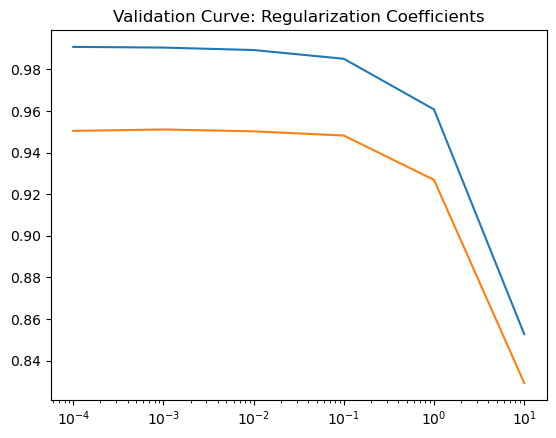

Exception ignored in: <function ResourceTracker.__del__ at 0x102ae9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f21bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1088a9bc0>
Traceback (most recent call last

In [ ]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE()),
        ("clf", BernoulliNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><u>Findings From 'Regularization Coefficients' Validation Curve</u></h3>
The plot suggests that the regularization coefficients will not help the generalization of the model since the scores are parallel to each other. On the other hand, the scores are very good especially when regularization is at its lowest. Therefore, a BernoulliNB model with a very low regularization coefficient is the best model to run in the cross-validation test.

In [76]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE()),
        ("clf", BernoulliNB())
    ]
) 
param_grid = {"clf__alpha": [0.009, 0.01, 0.03, 0.05, 0.1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_
print(nb_model)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................clf__alpha=0.009; total time=   0.8s
[CV] END ...................................clf__alpha=0.009; total time=   0.8s
[CV] END ...................................clf__alpha=0.009; total time=   0.8s
[CV] END ...................................clf__alpha=0.009; total time=   0.8s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ...................................clf__alpha=0.009; total time=   0.8s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ....................................clf__alpha=0.03; total time=   0.6s
[CV] END ....................................clf__alpha=0.03; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ....................................clf_

<h3><u>Bayesian Training Learning Curves</u><h3>

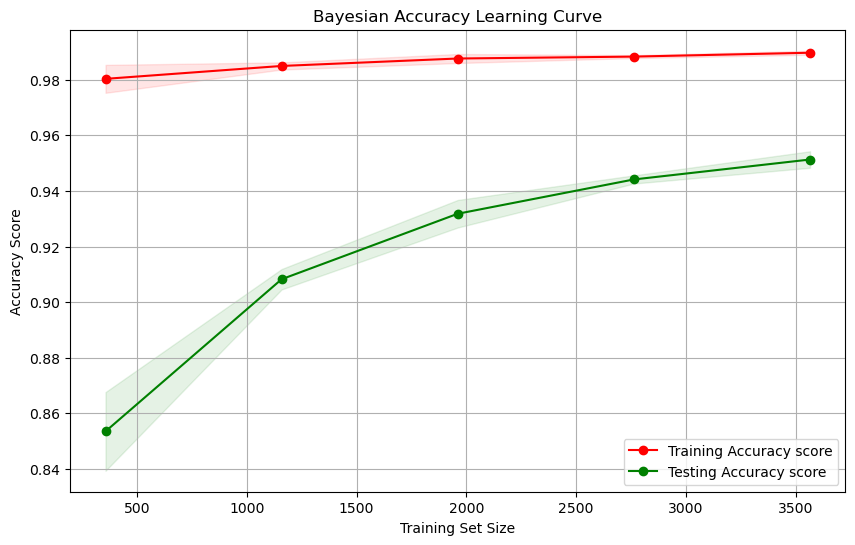

In [80]:
bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
    nb_model,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title(f"Bayesian Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel(f"Accuracy Score")
plt.grid()

plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
            label=f"Training Accuracy score")
plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
            label=f"Testing Accuracy score")

plt.legend(loc="best")
plt.show()

<ol>
<li>Describe what this learning curve is telling you about how your algorithm might perform if given more data.</li>
<p>After analyzing the learning curves from above, I can conclude that my Bayesian model does perform better when given more data especially in terms of the 'Precision' metric. Precision is the model's ability to correctly identify positives as positives. Therefore, precision is one of the most crucial metrics in determining the fit of a classification model. Since this model does an sufficient job at 'precision' as more training data is added, I would consider using this classfication model for this dataset.</p></br>

<li>That is, does it appear to still be learning even as you get to larger input sizes?</li>
<p>I do believe that the Bayesian model is capturing the logic of the data.</p></br>

<li>If you built an App to classify spam SMS messages, would that App be able to learn/improve from your user's classification of messages?</li>
<p>In my honest opinion, this model can be used for an SMS spam classifier app but I would be skeptical because of the skewed dataset.</p></br>
</ol>

<h2><strong><u>Metrics</u></strong></h2>

<h3><u>Bayesian Training Results<u></h3>

In [ ]:
#Cross-Validation Loop

nb_training_values = cross_val_score(nb_model, X_train, y_train, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.95403587 0.94618834 0.95510662 0.95173962 0.95061728]
0.95  +/-  0.0031 



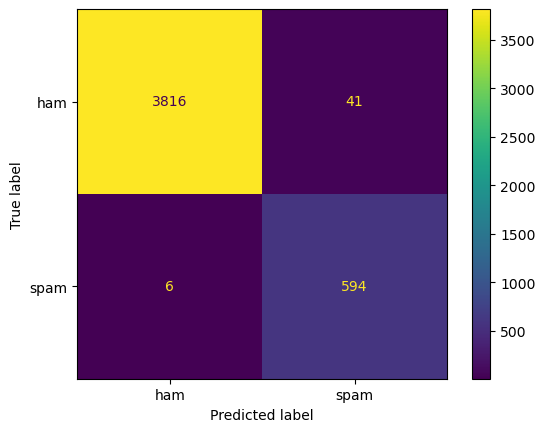

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_train, y_train)

In [83]:
train_predictions = nb_model.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train, train_predictions).ravel()
print("Precision Score", precision_score(y_train, train_predictions, pos_label='spam'))
print("Recall Score", recall_score(y_train, train_predictions, pos_label='spam'))
print("Negative Predictive Value Score", precision_score(y_train, train_predictions, pos_label='ham'))
print("Specificity Score", recall_score(y_train, train_predictions, pos_label='ham'))

Precision Score 0.9354330708661417
Recall Score 0.99
Negative Predictive Value Score 0.9984301412872841
Specificity Score 0.9893699766658024


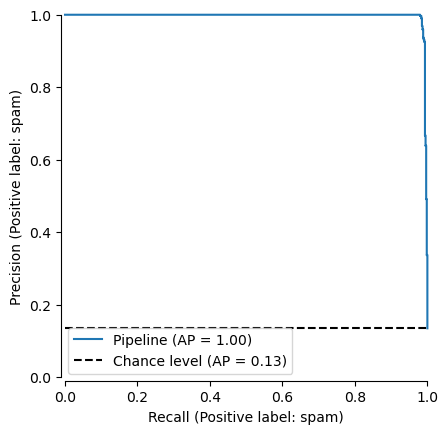

In [84]:
PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train, pos_label="spam", plot_chance_level=True, despine=True)

<ol>
<li>Did your classifier perform better than one that always predicted "ham"?</li>
<p>Yes, my model did perform better than one that always predicts "ham".</p></br>
<li>Were your testing metrics within the "bounds" set by your train/validation split (mean +/- std dev)?</li>
<p>Yes, for 'precision', I do believe that my testing metrics were within the "bounds" set by my train/validation split. On the other hand, the 'recall' metric was slightly above the "bounds".</p></br>
<li>Would you use this "bare" classifier as a filter on your own messages?</li>
<p>No, because I would like to see how it would score if given more data especially more 'spam' examples since the data was mostly 'ham' messages.</p></br>
</ol>

<h3><u>Bayesian Testing Results</u></h3>

In [12]:
nb_test_predictions = nb_model.predict(X_test)

nb_test_precision = precision_score(y_test, nb_test_predictions, average='macro')
print("Naive Bayes Test Precision: {:.2f}%".format(nb_test_precision * 100))

nb_test_recall = recall_score(y_test, nb_test_predictions, average='macro')
print("Naive Bayes Test Recall: {:.2f}%".format(nb_test_recall * 100))


Naive Bayes Test Precision: 99.34%
Naive Bayes Test Recall: 95.58%


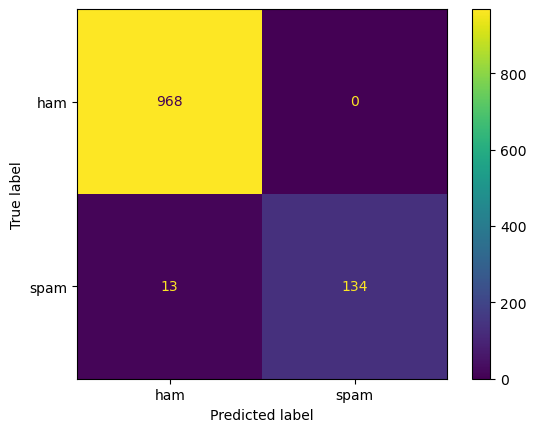

In [13]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, nb_test_predictions)

<h2><strong><u>TFIDF Vectorization and Logistic Classifier Model</u></strong></h2>

<h3><u>Pipeline Cross-Validation Model Selection</u></h3>

In [21]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", LogisticRegression())
    ]
)
param_grid = {
    "clf__penalty": ['l1', 'l2'], 
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100, 500],
    "vect__use_idf": [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
log_model = grid_search.best_estimator_
print(log_model)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimato

Best Parameters:  {'clf__C': 100, 'clf__penalty': 'l2', 'vect__use_idf': True}
Pipeline(steps=[('vect',
                 TfidfVectorizer(token_pattern=None,
                                 tokenizer=<function custom_tokenizer at 0x301e32f20>)),
                ('clf', LogisticRegression(C=100))])


<h3><u>TFIDF Vectorization and Logistic Classifier Training Results</u></h3>

In [22]:
for key, value in metrics.items():
    logistic_training_values = cross_val_score(log_model, X_train, y_train, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", logistic_training_values)
    np_logistic_training_values = np.array(logistic_training_values)
    average = np.mean(np_logistic_training_values)
    stDev = np.std(np_logistic_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Precision (Macro) training scores:  [0.97048039 0.97427845 0.98393971 0.98255284 0.96683404]
0.98  +/-  0.0067 

Cross-validation Recall (Macro) training scores:  [0.92657599 0.92305699 0.95286965 0.96888781 0.93009079]
0.94  +/-  0.0177 



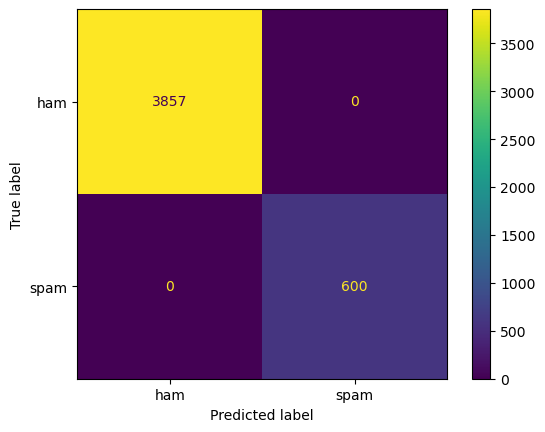

In [23]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_model, X_train, y_train)

<h3><u>TFIDF Vectorization and Logistic Classifier Testing Results</u></h3>

In [24]:
log_test_predictions = log_model.predict(X_test)

log_test_precision = precision_score(y_test, log_test_predictions, average='macro')
print("Naive Bayes Test Precision: {:.2f}%".format(log_test_precision * 100))

log_test_recall = recall_score(y_test, log_test_predictions, average='macro')
print("Naive Bayes Test Recall: {:.2f}%".format(log_test_recall * 100))


Naive Bayes Test Precision: 96.52%
Naive Bayes Test Recall: 95.17%


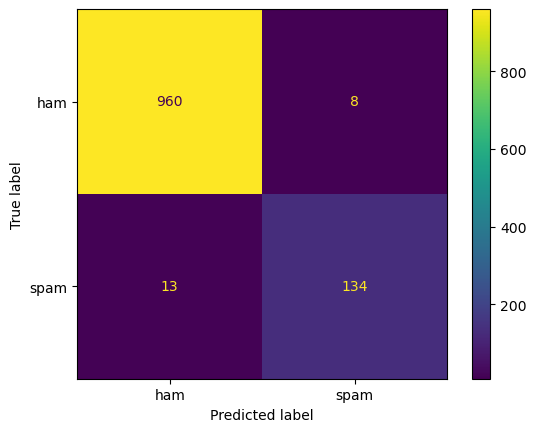

In [25]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, log_test_predictions)

<ol>
<li>Did your classifier perform better than one that always predicted "ham"?</li>
<p>Yes, my model did perform better than one that always predicts "ham".</p></br>
<li>Were your testing metrics within the "bounds" set by your train/validation split (mean +/- std dev)?</li>
<p>Yes, my testing metrics were within the "bounds" set by my train/validation split.</p></br>
<li>Would you use this "bare" classifier as a filter on your own messages?</li>
<p>No because I would like to see how it would score if given more data especially more 'spam' examples since the data was mostly 'ham' messages.</p></br>
</ol>

<h3><u>TFIDF Vectorization and Logistic Classifier Training Learning Curves</u></h3>

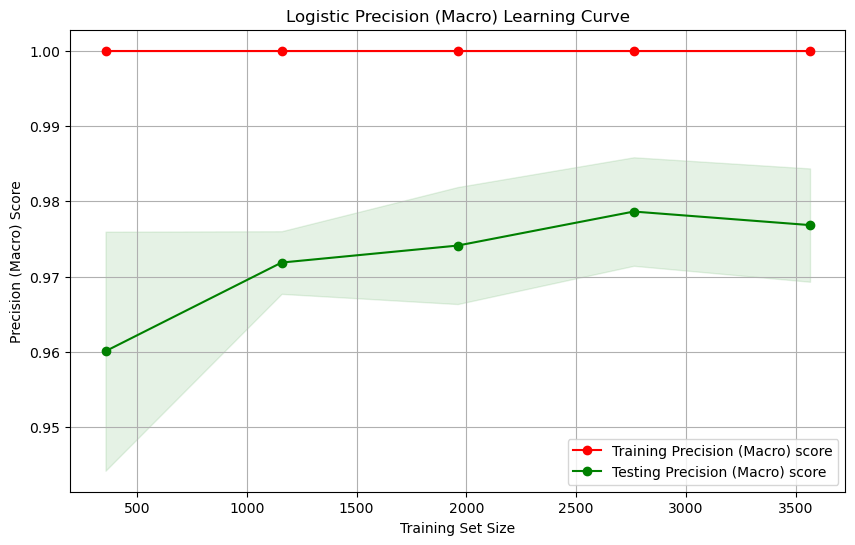

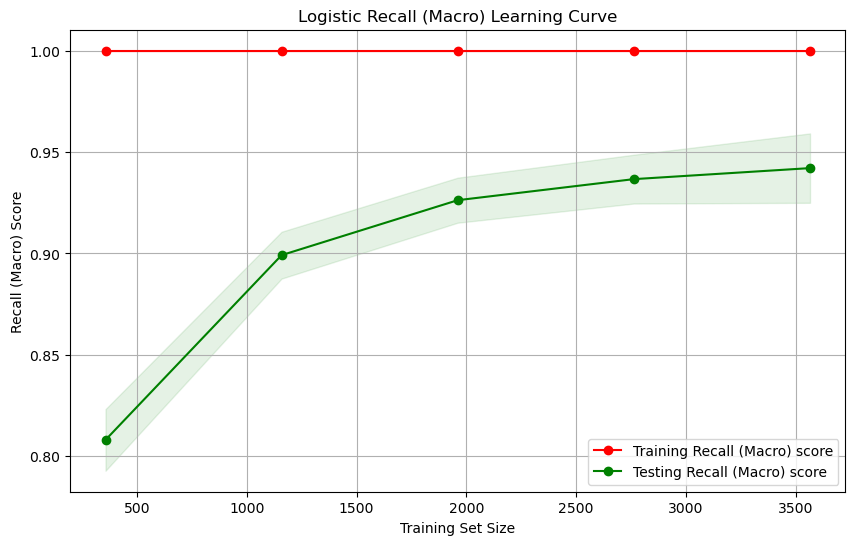

Exception ignored in: <function ResourceTracker.__del__ at 0x1063ddbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106e19bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102c81bc0>
Traceback (most recent call last

In [ ]:
for key, value in metrics.items():
    logistic_train_sizes, logistic_train_scores, logistic_test_scores = learning_curve(
        log_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
    logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
    logistic_test_scores_mean = np.mean(logistic_test_scores, axis=1)
    logistic_test_scores_std = np.std(logistic_test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Logistic {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(logistic_train_sizes, logistic_train_scores_mean - logistic_train_scores_std,
                    logistic_train_scores_mean + logistic_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(logistic_train_sizes, logistic_test_scores_mean - logistic_test_scores_std,
                    logistic_test_scores_mean + logistic_test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(logistic_train_sizes, logistic_train_scores_mean, 'o-', color="r",
             label=f"Training {key} score")
    plt.plot(logistic_train_sizes, logistic_test_scores_mean, 'o-', color="g",
             label=f"Testing {key} score")

    plt.legend(loc="best")
    plt.show()

<ol>
<li>Describe what this learning curve is telling you about how your algorithm might perform if given more data.</li>
<p>After analyzing the learning curves for the Logistic model, it can be seen that all of the curves are positive. This means that the model does a good job at correcting 'False Negatives' and correcting 'False Positives'. Therefore, I can say that the model will perform well when given more data.</p></br>
<li>That is, does it appear to still be learning even as you get to larger input sizes?</li>
<p>Yes, the positive learning curves from the logistic model lead to believe that the model is learning as it is receives larger input sizes.</p></br>
<li>If you built an App to classify spam SMS messages, would that App be able to learn/improve from your user's classification of messages?</li>
<p>Honestly, I would consider making it into an app especially since the learning curve from both metrics were positive.</p></br>
</ol>

<h2><u>Conclusions</u></h2>

<p style="font-size: 16px">From gathering results for both Bayesian and Logistic Models, I can conclude that, even though both models performed better than the baselines, the Bayesian model performed better on the data than the Logistic model did. The Bayesian model had better scores on the metrics than the Logistic model did. Therefore, I would choose to use the Bayesiam model instead of the Logistic model to solve these types of problems. Lastly, I believe that adding labeled data would improve both of these classifiers.</p>